# Classification with Dirichlet prior

In [8]:
%load_ext autoreload
%autoreload 2
import site
import time
site.addsitedir('..')

import jax
from jax.config import config
import jax.numpy as jnp
import numpy as np
from  matplotlib import pyplot as plt
from tqdm import tqdm

from jax.scipy.special import gammaln
from jax import random

from src.algorithm import mcmc

plt.rcParams["figure.figsize"]=6,6
#config.update("jax_enable_x64", True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setup

The probability vector $\pi$ is drawn from a Dirichlet distribution with parameter $\alpha$.

$\pi \sim \text{Dirichlet}(\alpha)$

The $K$ classes $x_1, \ldots, x_K$ are i.i.d. samples from a standard normal distribution and we have $N$ noisy observations $y_1, \ldots, y_N$ of the $K$ classes such that:

$y_i = x_{z_i} + \sigma \eta_i,$

where $\eta_i \sim \mathcal{N}(0,1)$ and $z_1, \ldots, z_N$ are drawn from a multinomial distribution with
probability vector $\pi$.

In [9]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))
key, *subkeys = random.split(key, 5)

In [10]:
K = 10
N = 1000
sigma = 0.03
alpha = 0.7 * jnp.ones(K,)
#alpha = jnp.array([10,10,2])

In [11]:
pi = random.dirichlet(subkeys[0], alpha)
z = random.categorical(subkeys[1], jnp.log(pi), shape = (N,))
print(f"pi = {pi}")

pi = [0.02057965 0.15362625 0.00132189 0.06220891 0.05961445 0.11808077
 0.37918943 0.1267799  0.07598194 0.00261679]


x = [-0.62295336  1.115157   -1.7955936  -1.7312781   0.02410522 -1.5064275
 -1.2588354   0.28980458  1.2364852   0.23111346]


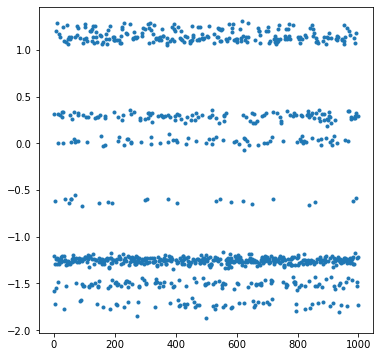

In [12]:
x = random.normal(subkeys[2], shape = (K,))
y = x[z] + sigma * random.normal(subkeys[3], shape = (N,))

print(f"x = {x}")
_ = plt.plot(y, '.')

### The posterior and proposal functions

In [261]:
# This log posterior marginalizes over the classes k = 1,...,K.
def logPi_marg(x, z, y, sigma, alpha):
    n_ik = calc_nik_jit(z)
    n_k = calc_nk_jit(z)
    
    log_arg = jnp.zeros(y.shape)
    #logPZalpha = -gammaln(jnp.sum(n_k) + jnp.sum(alpha))

    Nk = jnp.sum(n_k)
    Ak = jnp.sum(alpha)
    
    term_mat = []
    for k in jnp.arange(K):
        logarg_k = jnp.exp(-(y - x[k])**2/sigma) *  (n_ik[:, k] + alpha[k])/(Nk+Ak-1)
        log_arg += logarg_k
        term_mat.append(logarg_k)
        
        #logPZalpha += gammaln(n_k[k] + alpha[k])
      
    return jnp.sum(jnp.log(log_arg)) - jnp.sum(x**2) 
   
# And this does not.
def logPi(x, z, y, sigma, alpha):
    #n_ik = calc_nik_jit(z)
    #n_k = calc_nk_jit(z)
    
    #Nk = jnp.sum(n_k)
    #Ak = jnp.sum(alpha)
    
    #n_ik_z = jax.vmap(lambda i : n_ik[i, z[i]])(jnp.arange(N))
    
    term1 = jnp.sum(-(y - x[z])**2/sigma)
    #term2 = jnp.sum(jnp.log(n_ik_z + alpha[z])) 

    #logPZalpha = -gammaln(jnp.sum(n_k) + jnp.sum(alpha)) + jnp.sum(gammaln(n_k + alpha))

    #return term1 + term2 - jnp.sum(x**2) #+ logPZalpha 
    return term1 - jnp.sum(x**2) #+ logPZalpha 


def calc_nik_ki(z,k,i): 
    z = z.at[i].set(jnp.inf)    
    return jnp.sum(z == k)

calc_nik_i = lambda z, i : jax.vmap(calc_nik_ki, in_axes = (None, 0, None))(z, jnp.arange(K), i)
calc_nik = lambda z : jax.vmap(calc_nik_i, in_axes = (None, 0))(z, jnp.arange(N))
calc_nik_jit = jax.jit(calc_nik)

calc_nk_k = lambda z, k : jnp.sum(z == k)
calc_nk = lambda z : jax.vmap(calc_nk_k, in_axes = (None, 0))(z, jnp.arange(K))
calc_nk_jit = jax.jit(calc_nk)

In [262]:
print(logPi_marg(x, z, y, sigma, alpha))
print(logPi_marg(xi, zi, y, sigma, alpha))

-1625.2325
-1673.1879


In [263]:
print(logPi(x, z, y, sigma, alpha))
print(logPi(xi, zi, y, sigma, alpha))

-45.212353
-453.0128


In [264]:
@jax.jit
def proposal_x_marg(key, x0, logPiX0, B, z, y, sigma, alpha):
    """Proposal function of a new vector [x_1,...,x_k] from the posterior
    
    p(x_1, ..., x_K | y_1, ..., y_N)
    
    with marginalization over z_1,...z_N."""
    
    x1 = random.uniform(key, x0.shape) * 2*B-B
    
    logPiX0 = logPi_marg(x0, z, y, sigma, alpha)
    logPiX1 = logPi_marg(x1, z, y, sigma, alpha)
    
    r = jnp.exp((logPiX1 - logPiX0))
    
    return x1, r, logPiX1, logPiX0

@jax.jit
def proposal_x(key, x0, logPiX0, B, z, y, sigma, alpha):
    """Proposal function of a new vector [x_1,...,x_K] from the posterior
    
    p(x_1, ..., x_K, z_1, ..., y_N | y_1, ..., y_N)

    without marginalization over z_i variales (where we keep z_i fixed)."""
    
    x1 = random.uniform(key, x0.shape) * 2*B-B
    
    logPiX0 = logPi(x0, z, y, sigma, alpha)
    logPiX1 = logPi(x1, z, y, sigma, alpha)
    
    r = jnp.exp((logPiX1 - logPiX0))
    
    return x1, r, logPiX1, logPiX0

@jax.jit
def proposal_x_idx(key, x0, logPiX0, B, z, y, sigma, alpha, idx):
    """Proposal function for a new state x_{idx} from the posterior
    
    p(x_1, ..., x_K, z_1, ..., y_N | y_1, ..., y_N)
    
    where all z_i and the other x_j are fixed and with no
    marginalization over z.

    The returned vector x1 is equal to x0, 
    with the entry at index idx given by the proposal."""
    
    newval = random.uniform(key) * 2*B-B
    x1 = x0.at[idx].set(newval)
    
    logPiX0 = logPi(x0, z, y, sigma, alpha)
    logPiX1 = logPi(x1, z, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return x1, r, logPiX1, logPiX0    
               

@jax.jit
def proposal_z(key, z0, logPiX0, x, y, sigma, alpha, K):
    """Proposal function of a new vector [z_1,...,z_N] from the posterior
    
    p(x_1, ..., x_K, z_1, ..., y_N | y_1, ..., y_N)

    where the x_i variables are fixed."""
    
    z1 = random.randint(key, z0.shape, 0, K) 

    logPiX0 = logPi(x, z0, y, sigma, alpha)
    logPiX1 = logPi(x, z1, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return z1, r, logPiX1, logPiX0

@jax.jit
def proposal_z_idx(key, z0, logPiX0, x, y, sigma, alpha, K, idx):
    """Proposal function of a new state z_{idx} from the posterior
    
    p(x_1, ..., x_K, z_1, ..., y_N | y_1, ..., y_N)

    where all x_i and the other z_j are fixed.
    
    The returned vector z1 is equal to z0, 
    with the entry at index idx given by the proposal."""
    
    newval = random.randint(key, (), 0, K) 
    z1 = z0.at[idx].set(newval)
    
    logPiX0 = logPi(x, z0, y, sigma, alpha)
    logPiX1 = logPi(x, z1, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return z1, r, logPiX1, logPiX0

### Sample x

In [230]:
print(f"pi = {pi}")
print(f"x = {x}")

pi = [0.02057965 0.15362625 0.00132189 0.06220891 0.05961445 0.11808077
 0.37918943 0.1267799  0.07598194 0.00261679]
x = [-0.62295336  1.115157   -1.7955936  -1.7312781   0.02410522 -1.5064275
 -1.2588354   0.28980458  1.2364852   0.23111346]


In [231]:
#z_rand = random.categorical(subkey, jnp.log(pi), shape = (N,))
#z_rand = random.randint(subkey, (N,), 0, K)

#### Sampling the marginalized posterior

  MCMC sample 1000, loss = -2083.704833984375, a = 0.0
  MCMC sample 2000, loss = -2058.4375, a = 0.0
  MCMC sample 3000, loss = -2058.4375, a = 0.0
  MCMC sample 4000, loss = -2058.4375, a = 0.0
  MCMC sample 5000, loss = -2058.4375, a = 0.0
  MCMC sample 6000, loss = -2058.4375, a = 0.0
  MCMC sample 7000, loss = -2058.4375, a = 0.0
  MCMC sample 8000, loss = -1973.4517822265625, a = 0.0
  MCMC sample 9000, loss = -1973.4517822265625, a = 0.0
26.80777096748352 sec
x_samp = [ 2.343645    0.0444417   2.5398283  -0.8179114   1.1403437  -0.02741504
 -1.3150091   0.18550229 -1.8715103  -2.2783449 ]
x_true = [-0.62295336  1.115157   -1.7955936  -1.7312781   0.02410522 -1.5064275
 -1.2588354   0.28980458  1.2364852   0.23111346]


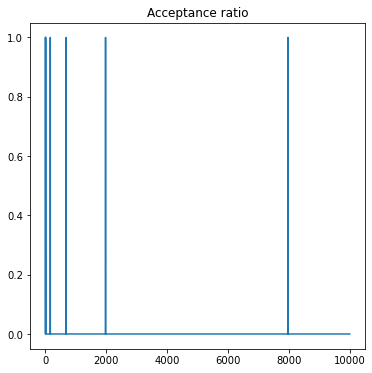

In [232]:
N_samples_x = 10000
x0 = jnp.array(np.random.randn(K))
B = 3

params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha}

key, subkey = random.split(key)
t0 = time.time()
x_mean, x_r, x_samples = mcmc(subkey, proposal_x_marg, x0, N_samples_x, params_x, 1, 1)

print(f"{time.time()-t0} sec")
plt.plot(x_r); plt.title("Acceptance ratio")
print(f"x_samp = {x_samples[N_samples_x-2]}")
print(f"x_true = {x}")

#### And the non-marginalized posterior

  MCMC sample 1000, loss = -25948.99609375, a = 0.0
  MCMC sample 2000, loss = -20544.392578125, a = 0.0
  MCMC sample 3000, loss = -6341.39013671875, a = 0.0
  MCMC sample 4000, loss = -6341.39013671875, a = 0.0
  MCMC sample 5000, loss = -6341.39013671875, a = 0.0
  MCMC sample 6000, loss = -6341.39013671875, a = 0.0
  MCMC sample 7000, loss = -6341.39013671875, a = 0.0
  MCMC sample 8000, loss = -6341.39013671875, a = 0.0
  MCMC sample 9000, loss = -6341.39013671875, a = 0.0
2.8736140727996826 sec
x_samp = [-1.4944489   1.453989   -2.473541   -1.6175301   0.6145556  -1.2561808
 -1.5834897   0.34944963  1.7676287  -0.40471816]
x_true = [-0.62295336  1.115157   -1.7955936  -1.7312781   0.02410522 -1.5064275
 -1.2588354   0.28980458  1.2364852   0.23111346]


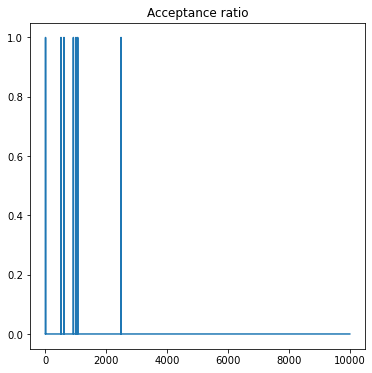

In [234]:
N_samples_x = 10000
x0 = jnp.array(np.random.randn(K))
B = 3

params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha}

key, subkey = random.split(key)
t0 = time.time()
x_mean, x_r, x_samples = mcmc(subkey, proposal_x, x0, N_samples_x, params_x, 1, 1)

print(f"{time.time()-t0} sec")
plt.plot(x_r); plt.title("Acceptance ratio")
print(f"x_samp = {x_samples[N_samples_x-2]}")
print(f"x_true = {x}")

#### One $x_i$ at a time

  MCMC sample 1000, loss = -95341.7265625, a = 2.3014721621934754e-16
  MCMC sample 2000, loss = -95342.1796875, a = 0.0
  MCMC sample 3000, loss = -95342.421875, a = 0.0
  MCMC sample 4000, loss = -95341.7890625, a = 0.0
  MCMC sample 5000, loss = -95341.75, a = 5.2903204549297617e-14
  MCMC sample 6000, loss = -95342.140625, a = 0.0
  MCMC sample 7000, loss = -95341.78125, a = 1.109573752322568e-10
  MCMC sample 8000, loss = -95341.9921875, a = 0.0
  MCMC sample 9000, loss = -95341.7734375, a = 0.0
  MCMC sample 10000, loss = -95341.78125, a = 0.0
3.4865100383758545 sec
x_samp = [ 0.7929072   0.74618524 -1.8609095   0.8959445   1.6639999   0.60163486
  0.76820886  0.28752977  0.47081533 -3.548173  ]
x_true = [-0.62295336  1.115157   -1.7955936  -1.7312781   0.02410522 -1.5064275
 -1.2588354   0.28980458  1.2364852   0.23111346]


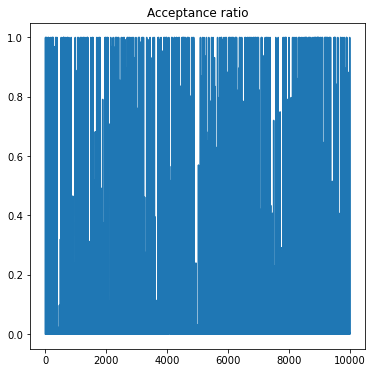

In [235]:
N_samples_x = 10001
B = 3

idx = 2
x0 = jnp.array(np.random.randn(K))

params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha, "idx": idx}

key, subkey = random.split(key)
t0 = time.time()
x_mean, x_r, x_samples = mcmc(subkey, proposal_x_idx, x0, N_samples_x, params_x, 1, 1)

print(f"{time.time()-t0} sec")
plt.plot(x_r); plt.title("Acceptance ratio")
print(f"x_samp = {x_samples[N_samples_x-2]}")
print(f"x_true = {x}")

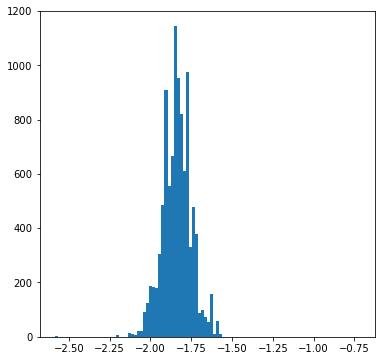

In [236]:
nbins=100
counts, bins = np.histogram(x_samples[:,idx], bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

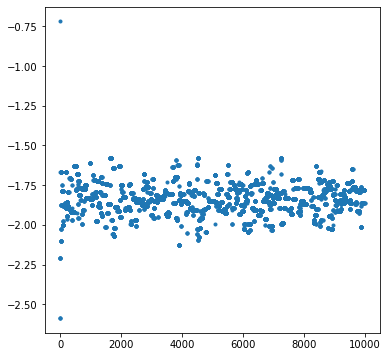

In [237]:
plt.plot(x_samples[:,idx],'.')

### Sample z

  MCMC sample 1000, loss = -80211.6796875, a = 1.2138925345224891e-23
0.3079371452331543 sec
z[idx]_samp = 8
z[idx]_true = 8


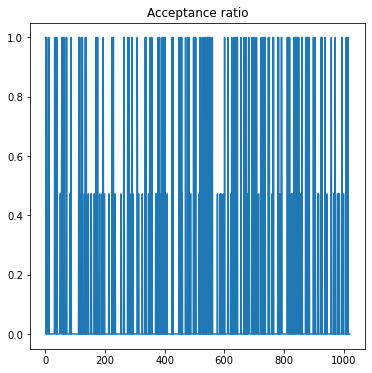

In [249]:
N_samples_z = 1023
z0 = jnp.array(np.random.randint(0, K, (N,)))
#z0 = z.at[idx].set(np.random.randint(0,K,()))

B = 2
idx = 10
params_z = {"x" : x, "y" : y, "sigma" : sigma, "alpha" : alpha, "K" : K, 'idx' : idx}

key, subkey = random.split(key)

t0 = time.time()
z_mean, z_r, z_samples = mcmc(subkey, proposal_z_idx, z0, N_samples_z, params_z, 1, 1)

z_samples = z_samples[:,idx]

print(f"{time.time()-t0} sec")
plt.plot(z_r); plt.title("Acceptance ratio")
print(f"z[idx]_samp = {z_samples[N_samples_z-2]}")
print(f"z[idx]_true = {z[idx]}")


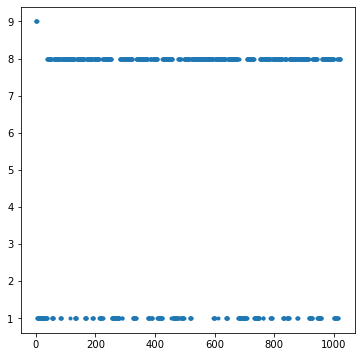

In [250]:
plt.plot(z_samples, '.')

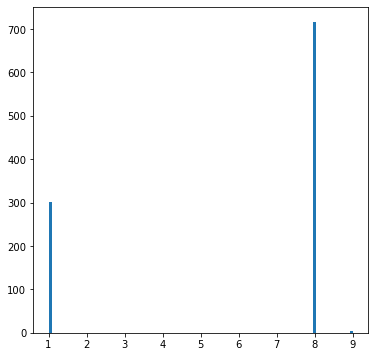

In [248]:
nbins=100
counts, bins = np.histogram(z_samples, bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

### Sample $x$ and $z$

In [265]:
N_iters = 10
N_samples_z = 50 #300
N_samples_x = 3001
B = 3

sample_x = True
sample_z = True
search_z = False

zi = jnp.array(np.random.randint(0, K, (N,)))
xi = jnp.array(np.random.randn(K))

#xi = x
#zi = z

t0 = time.time()
for iter_i in jnp.arange(N_iters):
    print(f"Iter = {iter_i}")

    if sample_x:
        print("  Sampling x")
        for idx_x in jnp.arange(K):

            params_x = {"B" : B, "z" : zi, "y" : y, "sigma" : sigma, "alpha" : alpha, "idx": idx_x}
            #params_x = {"B" : B, "z" : zi, "y" : y, "sigma" : sigma, "alpha" : alpha}

            key, subkey = random.split(key)
    
            #t0 = time.time()
            x_mean, x_r, x_samples = mcmc(subkey, proposal_x_idx, xi, N_samples_x, params_x, 1, 1) 
            #x_mean, x_r, x_samples = mcmc(subkey, proposal_x_marg, xi, N_samples_x, params_x, 1, 1) 

            xi = x_samples[N_samples_x - 2]
    
    if search_z:
        print("  Searching z")
        for idx_z in tqdm(jnp.arange(N)):
            logPi_max = -jnp.inf

            for ki in jnp.arange(K):
                zi_k = zi.at[idx_z].set(ki)
                logPi_k = logPi(xi, zi_k, y, sigma, alpha)
                if logPi_k > logPi_max:
                    zi = zi_k
                    logPi_max = logPi_k
            
    if sample_z:
        print("  Sampling z")
        for idx_z in tqdm(jnp.arange(N)):
            
            params_z = {"x" : xi, "y" : y, "sigma" : sigma, "alpha" : alpha, "K" : K, 'idx' : idx_z}

            key, subkey = random.split(key)

            z_mean, z_r, z_samples = mcmc(subkey, proposal_z_idx, zi, N_samples_z, params_z, 1, 1)

            zi = z_samples[N_samples_z - 2]
            
            #new_zi = jnp.bincount(z_samples[:,idx_z]).argmax()
            #zi = zi.at[idx_z].set(new_zi)
            
            #if zi[idx_z] - z[idx_z] != 0:
            #    break
            

print(f"{time.time()-t0} sec")
print(f"x_samp = {xi}")
print(f"x_true = {x}")

Iter = 0
  Sampling x
  MCMC sample 1000, loss = -81944.484375, a = 0.0
  MCMC sample 2000, loss = -81944.28125, a = 0.0
  MCMC sample 3000, loss = -81943.828125, a = 0.0
  MCMC sample 1000, loss = -66264.625, a = 0.0
  MCMC sample 2000, loss = -66264.3984375, a = 0.0
  MCMC sample 3000, loss = -66264.5390625, a = 0.0
  MCMC sample 1000, loss = -63258.140625, a = 0.0
  MCMC sample 2000, loss = -63256.73828125, a = 0.0
  MCMC sample 3000, loss = -63256.69921875, a = 0.0
  MCMC sample 1000, loss = -54705.71875, a = 0.0
  MCMC sample 2000, loss = -54705.75390625, a = 0.0
  MCMC sample 3000, loss = -54705.96875, a = 0.0
  MCMC sample 1000, loss = -48637.9765625, a = 0.0
  MCMC sample 2000, loss = -48637.98828125, a = 0.0
  MCMC sample 3000, loss = -48639.0625, a = 2.8181744213705002e-33
  MCMC sample 1000, loss = -46228.09765625, a = 0.0
  MCMC sample 2000, loss = -46229.59375, a = 0.0
  MCMC sample 3000, loss = -46228.58203125, a = 0.0
  MCMC sample 1000, loss = -46162.69921875, a = 2.034

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 65.84it/s]


Iter = 1
  Sampling x
  MCMC sample 1000, loss = -29698.20703125, a = 0.0
  MCMC sample 2000, loss = -29698.373046875, a = 0.0
  MCMC sample 3000, loss = -29697.919921875, a = 0.0
  MCMC sample 1000, loss = -25603.271484375, a = 0.0
  MCMC sample 2000, loss = -25603.466796875, a = 0.0
  MCMC sample 3000, loss = -25603.607421875, a = 0.0
  MCMC sample 1000, loss = -25604.095703125, a = 0.08144620805978775
  MCMC sample 2000, loss = -25603.21875, a = 0.0
  MCMC sample 3000, loss = -25603.37109375, a = 0.7941612601280212
  MCMC sample 1000, loss = -25603.451171875, a = 0.0
  MCMC sample 2000, loss = -25603.13671875, a = 2.563265229745671e-27
  MCMC sample 3000, loss = -25603.498046875, a = 0.0
  MCMC sample 1000, loss = -23358.580078125, a = 0.0
  MCMC sample 2000, loss = -23358.4140625, a = 0.0
  MCMC sample 3000, loss = -23359.037109375, a = 0.0
  MCMC sample 1000, loss = -9196.0234375, a = 0.0
  MCMC sample 2000, loss = -9196.08984375, a = 0.0
  MCMC sample 3000, loss = -9195.9453125, 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.69it/s]


Iter = 2
  Sampling x
  MCMC sample 1000, loss = -2244.83642578125, a = 0.0
  MCMC sample 2000, loss = -2250.019287109375, a = 0.0
  MCMC sample 3000, loss = -2244.4296875, a = 0.0
  MCMC sample 1000, loss = -2229.53564453125, a = 0.00025973221636377275
  MCMC sample 2000, loss = -2229.081787109375, a = 0.0
  MCMC sample 3000, loss = -2229.091064453125, a = 0.0
  MCMC sample 1000, loss = -2228.37744140625, a = 0.0
  MCMC sample 2000, loss = -2228.373779296875, a = 0.0
  MCMC sample 3000, loss = -2228.34912109375, a = 0.0
  MCMC sample 1000, loss = -2226.865478515625, a = 0.0
  MCMC sample 2000, loss = -2226.85546875, a = 0.004201086238026619
  MCMC sample 3000, loss = -2226.95947265625, a = 0.9572399854660034
  MCMC sample 1000, loss = -2226.32421875, a = 0.0
  MCMC sample 2000, loss = -2225.93212890625, a = 0.0
  MCMC sample 3000, loss = -2229.009521484375, a = 0.0
  MCMC sample 1000, loss = -940.613525390625, a = 0.0
  MCMC sample 2000, loss = -939.525634765625, a = 0.0
  MCMC sample

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.09it/s]


Iter = 3
  Sampling x
  MCMC sample 1000, loss = -596.9835815429688, a = 0.0
  MCMC sample 2000, loss = -596.5261840820312, a = 0.0
  MCMC sample 3000, loss = -599.163818359375, a = 0.0
  MCMC sample 1000, loss = -595.1318359375, a = 0.0
  MCMC sample 2000, loss = -593.5750122070312, a = 0.0
  MCMC sample 3000, loss = -595.0625, a = 0.0
  MCMC sample 1000, loss = -595.1483154296875, a = 1.0
  MCMC sample 2000, loss = -595.0620727539062, a = 3.540157108052238e-31
  MCMC sample 3000, loss = -595.8050537109375, a = 0.0
  MCMC sample 1000, loss = -594.8942260742188, a = 0.0
  MCMC sample 2000, loss = -593.4362182617188, a = 0.0
  MCMC sample 3000, loss = -593.4962768554688, a = 0.0
  MCMC sample 1000, loss = -593.95654296875, a = 0.0
  MCMC sample 2000, loss = -593.4094848632812, a = 0.0
  MCMC sample 3000, loss = -594.1592407226562, a = 0.0
  MCMC sample 1000, loss = -591.9979858398438, a = 0.0
  MCMC sample 2000, loss = -591.6719360351562, a = 0.0
  MCMC sample 3000, loss = -591.76708984

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.92it/s]


Iter = 4
  Sampling x
  MCMC sample 1000, loss = -523.953857421875, a = 0.0
  MCMC sample 2000, loss = -524.0838623046875, a = 0.0
  MCMC sample 3000, loss = -524.2635498046875, a = 0.0
  MCMC sample 1000, loss = -501.65374755859375, a = 0.0
  MCMC sample 2000, loss = -501.7372131347656, a = 0.0
  MCMC sample 3000, loss = -502.3566589355469, a = 0.0
  MCMC sample 1000, loss = -500.16009521484375, a = 2.8923386707901955e-07
  MCMC sample 2000, loss = -500.24920654296875, a = 0.0
  MCMC sample 3000, loss = -500.2808837890625, a = 0.0
  MCMC sample 1000, loss = -501.6613464355469, a = 0.3823823630809784
  MCMC sample 2000, loss = -500.6864318847656, a = 0.0
  MCMC sample 3000, loss = -500.4615173339844, a = 0.0
  MCMC sample 1000, loss = -485.44891357421875, a = 0.0
  MCMC sample 2000, loss = -485.38287353515625, a = 2.9239694049233e-20
  MCMC sample 3000, loss = -485.37042236328125, a = 0.0
  MCMC sample 1000, loss = -485.31768798828125, a = 0.0
  MCMC sample 2000, loss = -485.2946777343

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.69it/s]


Iter = 5
  Sampling x
  MCMC sample 1000, loss = -358.1984558105469, a = 0.0
  MCMC sample 2000, loss = -358.5600280761719, a = 0.0
  MCMC sample 3000, loss = -358.3044738769531, a = 0.0
  MCMC sample 1000, loss = -339.355712890625, a = 0.0
  MCMC sample 2000, loss = -340.4490051269531, a = 0.0
  MCMC sample 3000, loss = -339.598388671875, a = 0.0
  MCMC sample 1000, loss = -339.5984802246094, a = 1.719299871183466e-05
  MCMC sample 2000, loss = -339.8990478515625, a = 0.0
  MCMC sample 3000, loss = -339.7532958984375, a = 0.0
  MCMC sample 1000, loss = -338.5280456542969, a = 0.0
  MCMC sample 2000, loss = -340.0050354003906, a = 0.0
  MCMC sample 3000, loss = -338.51739501953125, a = 0.0
  MCMC sample 1000, loss = -334.87799072265625, a = 0.0
  MCMC sample 2000, loss = -334.8990173339844, a = 0.0
  MCMC sample 3000, loss = -334.7533874511719, a = 0.0
  MCMC sample 1000, loss = -334.9631652832031, a = 0.0
  MCMC sample 2000, loss = -335.90380859375, a = 0.0
  MCMC sample 3000, loss = 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.85it/s]


Iter = 6
  Sampling x
  MCMC sample 1000, loss = -317.12554931640625, a = 0.0
  MCMC sample 2000, loss = -317.1289367675781, a = 0.0
  MCMC sample 3000, loss = -317.2940673828125, a = 0.0
  MCMC sample 1000, loss = -315.8383483886719, a = 0.5581657290458679
  MCMC sample 2000, loss = -315.5100402832031, a = 0.0
  MCMC sample 3000, loss = -315.6418151855469, a = 0.0
  MCMC sample 1000, loss = -315.61865234375, a = 0.0
  MCMC sample 2000, loss = -316.0836181640625, a = 0.0004090278525836766
  MCMC sample 3000, loss = -315.79742431640625, a = 0.0
  MCMC sample 1000, loss = -315.7696228027344, a = 3.456480772001669e-05
  MCMC sample 2000, loss = -315.77813720703125, a = 0.0
  MCMC sample 3000, loss = -315.7479553222656, a = 0.0
  MCMC sample 1000, loss = -314.5334777832031, a = 0.0
  MCMC sample 2000, loss = -314.497802734375, a = 2.3277503657936904e-07
  MCMC sample 3000, loss = -315.0364685058594, a = 0.0
  MCMC sample 1000, loss = -313.9044494628906, a = 0.0
  MCMC sample 2000, loss = -

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.88it/s]


Iter = 7
  Sampling x
  MCMC sample 1000, loss = -306.1079406738281, a = 0.0
  MCMC sample 2000, loss = -307.0122375488281, a = 0.0
  MCMC sample 3000, loss = -306.1150207519531, a = 0.0
  MCMC sample 1000, loss = -306.2450256347656, a = 0.0
  MCMC sample 2000, loss = -306.4588928222656, a = 0.0
  MCMC sample 3000, loss = -306.1199035644531, a = 0.0
  MCMC sample 1000, loss = -306.0982666015625, a = 0.0
  MCMC sample 2000, loss = -305.9222412109375, a = 8.587874094044522e-25
  MCMC sample 3000, loss = -306.46966552734375, a = 0.0
  MCMC sample 1000, loss = -307.81103515625, a = 0.0
  MCMC sample 2000, loss = -306.3252868652344, a = 0.0
  MCMC sample 3000, loss = -307.6121520996094, a = 0.0
  MCMC sample 1000, loss = -307.6333923339844, a = 0.0
  MCMC sample 2000, loss = -307.3760070800781, a = 0.0
  MCMC sample 3000, loss = -307.3824157714844, a = 0.0
  MCMC sample 1000, loss = -307.5091247558594, a = 0.0
  MCMC sample 2000, loss = -307.8675537109375, a = 0.0
  MCMC sample 3000, loss =

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.72it/s]


Iter = 8
  Sampling x
  MCMC sample 1000, loss = -312.0456848144531, a = 0.0
  MCMC sample 2000, loss = -310.6102600097656, a = 0.0
  MCMC sample 3000, loss = -310.6037292480469, a = 0.0
  MCMC sample 1000, loss = -310.94378662109375, a = 0.0
  MCMC sample 2000, loss = -310.656494140625, a = 0.0
  MCMC sample 3000, loss = -310.6034240722656, a = 0.0
  MCMC sample 1000, loss = -310.0519714355469, a = 0.0
  MCMC sample 2000, loss = -310.8788146972656, a = 1.1896746118909462e-29
  MCMC sample 3000, loss = -309.9927062988281, a = 0.0
  MCMC sample 1000, loss = -309.3190612792969, a = 3.4173697258665925e-06
  MCMC sample 2000, loss = -308.96685791015625, a = 1.0
  MCMC sample 3000, loss = -311.166748046875, a = 0.0
  MCMC sample 1000, loss = -312.5806579589844, a = 0.0
  MCMC sample 2000, loss = -311.5661926269531, a = 0.0
  MCMC sample 3000, loss = -311.0108337402344, a = 0.0
  MCMC sample 1000, loss = -311.36865234375, a = 0.0
  MCMC sample 2000, loss = -311.68194580078125, a = 0.0
  MCMC

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.91it/s]


Iter = 9
  Sampling x
  MCMC sample 1000, loss = -319.3101501464844, a = 0.0
  MCMC sample 2000, loss = -321.70330810546875, a = 0.0
  MCMC sample 3000, loss = -320.4195556640625, a = 0.0
  MCMC sample 1000, loss = -321.6682434082031, a = 0.0
  MCMC sample 2000, loss = -320.18499755859375, a = 0.0
  MCMC sample 3000, loss = -320.5242614746094, a = 0.0
  MCMC sample 1000, loss = -320.99920654296875, a = 0.0
  MCMC sample 2000, loss = -320.9148254394531, a = 0.0
  MCMC sample 3000, loss = -321.73736572265625, a = 0.0
  MCMC sample 1000, loss = -318.8197326660156, a = 0.0
  MCMC sample 2000, loss = -318.77764892578125, a = 0.0
  MCMC sample 3000, loss = -319.7479248046875, a = 0.0
  MCMC sample 1000, loss = -319.7867126464844, a = 0.0
  MCMC sample 2000, loss = -320.5010986328125, a = 0.0
  MCMC sample 3000, loss = -319.68743896484375, a = 0.0
  MCMC sample 1000, loss = -319.57342529296875, a = 0.0
  MCMC sample 2000, loss = -319.986572265625, a = 0.0
  MCMC sample 3000, loss = -319.50692

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.95it/s]

225.43588995933533 sec
x_samp = [-1.2957838  -1.6020019  -0.55089927 -0.6688907  -1.2890997   1.1552796
  0.19181657 -0.62851095 -1.2819464  -0.6419227 ]
x_true = [-0.62295336  1.115157   -1.7955936  -1.7312781   0.02410522 -1.5064275
 -1.2588354   0.28980458  1.2364852   0.23111346]


152
117
2
7
147
229
190
7
141
8
0


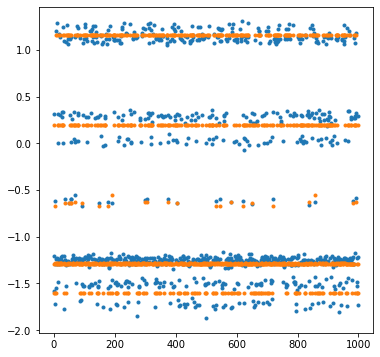

In [266]:
plt.plot(y, '.')
plt.plot(xi[zi], '.')

print(jnp.sum(zi==0))
print(jnp.sum(zi==1))
print(jnp.sum(zi==2))
print(jnp.sum(zi==3))
print(jnp.sum(zi==4))
print(jnp.sum(zi==5))
print(jnp.sum(zi==6))
print(jnp.sum(zi==7))
print(jnp.sum(zi==8))
print(jnp.sum(zi==9))
print(jnp.sum(zi==10))

In [267]:
logPiZ0 = logPi(xi, zi, y, sigma, alpha)
logPiZ1 = logPi(xi, zi.at[18].set(2), y, sigma, alpha)

jnp.exp(logPiZ1-logPiZ0)

DeviceArray(0., dtype=float32)

In [268]:
print(logPi(x, z, y, sigma, alpha))
print(logPi(xi, zi, y, sigma, alpha))

-45.212353
-326.29855


In [64]:
z1 = z.at[0].set(1)
logPiZ0 = logPi(x, z, y, sigma, alpha)
logPiZ1 = logPi(x, z1, y, sigma, alpha)
r = jnp.exp(logPiZ1 - logPiZ0)
r

DeviceArray(0., dtype=float32)

24
154
2
55
69
108
392
118
75
3
0


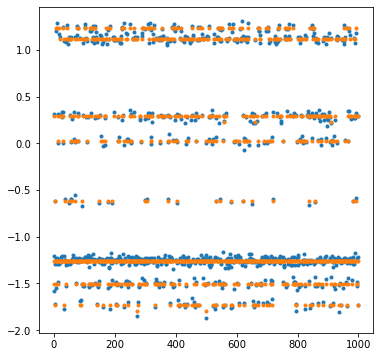

In [184]:
plt.plot(y, '.')
plt.plot(x[z], '.')

print(jnp.sum(z==0))
print(jnp.sum(z==1))
print(jnp.sum(z==2))
print(jnp.sum(z==3))
print(jnp.sum(z==4))
print(jnp.sum(z==5))
print(jnp.sum(z==6))
print(jnp.sum(z==7))
print(jnp.sum(z==8))
print(jnp.sum(z==9))
print(jnp.sum(z==10))

In [ ]:
print(pi)
print(x)
print(xi)

In [ ]:
# Loss functions roughly equivalent with the the estimation problem to see what's going on
def loss_fun(x, z, y):
    return (x[z] - y)**2 * pi[z]

def loss_fun_vmap(x,z,y):
    n_k = calc_nk_jit(z)
    logPZalpha = -gammaln(jnp.sum(n_k) + jnp.sum(alpha)) + jnp.sum(gammaln(n_k + alpha))
    print(f"logPZalpha = {-logPZalpha}")
    return jnp.sum(jax.vmap(loss_fun, in_axes = (None, 0, 0))(x,z,y)) + jnp.sum(x**2) - logPZalpha

In [ ]:
n_k = calc_nk_jit(z)
logPZalpha = -gammaln(jnp.sum(n_k) + jnp.sum(alpha)) + jnp.sum(gammaln(n_k + alpha))

In [ ]:
jnp.sum(gammaln(n_k+alpha))

In [ ]:
gammaln(jnp.sum(n_k) + jnp.sum(alpha))

In [ ]:
alpha.shape

In [ ]:
print(loss_fun_vmap(x, jnp.array(np.random.randint(0, K, (N,))), y))
print(loss_fun_vmap(xi, zi, y))
print(loss_fun_vmap(x, z, y))

In [ ]:
alpha

### Some functions used for debugging - ignore

In [ ]:
# Quick test of a proposal function
key, subkey = random.split(key)
idx = 1
z1, rz, _, _ = proposal_z_idx(subkey, z, -1, x, y, sigma, alpha, K, idx)
print(z1[idx])
print(rz)

In [ ]:
key, subkey = random.split(key)
#z0 = random.randint(subkey, z.shape, 0, K)
z0 = jnp.ones(z.shape)
z0 = z

n_ik_z = calc_nik_jit(z0)
n_k = calc_nk_jit(z0)
Nk = jnp.sum(n_k)
Ak = jnp.sum(alpha)

In [ ]:
probs_d = []
probs_dn = []
for k in jnp.arange(K):
    probs_d.append((n_ik_z[:, k] + alpha[k])/(Nk+Ak-1))
    probs_dn.append((n_ik_z[:, k])/(Nk-1))

probs_d = jnp.array(probs_d).transpose()   
probs_dn = jnp.array(probs_dn).transpose()   

print(probs_d)
#print(jnp.sum(probs_d, axis=1))

plt.imshow(jnp.repeat(probs_d, int(N/K), axis=1)); plt.colorbar()

In [ ]:
myf = lambda x0, x1 : logPi(jnp.array([x0, x1]), z, y, sigma, alpha)
xx = jnp.linspace(-3,3,1000)    
yy = jnp.linspace(-3,3,1000)

In [ ]:
myf_x = jax.jit(lambda x : jax.vmap(myf, in_axes = (None, 0))(x, yy))
myf_xy = jax.vmap(myf_x)(xx)

In [ ]:
plt.imshow((myf_xy)); plt.colorbar()

In [ ]:
print("01", myf(x[0], x[1]))
print("00", myf(x[0], x[0]))
print("11", myf(x[1], x[1]))
print("10", myf(x[1], x[0]))

In [ ]:
myf(x[0],x[1])

In [ ]:
jnp.max(myf_xy)